# Flash:   A neural network for climbing route recognition 

### by Jon Toledo 

# Introduction 

Flash is a convolutional neural network which classifies images of climbing routes.  The network is trained using about 200 images of each route from various positions.  The challenge is then to identify new images taken from arbitrary positions and under arbitrary conditions (weather, time of day, season).

The first step is just to concentrate on training data and testing data collected on the same day, but independently by different people from different positions.  This is a fairly simple problem of image recognition, and excellent results of 99% can be achieved with simple versions of standard architecture.  

Of course one will eventually need to ensure generalization to different conditions (e.g. weather, time of day, season).  It is not practical to collect training data under all possible conditions, so we need to design a neural network which focuses on the qualities of the route which are invariant under these changes. For this, image pre-processing will play a key role.

# Libraries and packages 

In [7]:
# for the image preprocessing
import os
from shutil import copyfile, rmtree
import random
import cv2
import imageio
from PIL import Image
from scipy import ndimage

# for the neural network
from keras import backend as K 
K.clear_session()

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from keras import regularizers

from keras.preprocessing import image
from keras.utils.vis_utils import plot_model

# generally useful
import numpy as np
import matplotlib.pyplot as plt

# Data 

I choose 4 different climbing routes in a popular sector of the local climbing area Mount Nemo. Lets call them route 1, ...., route 4. I took 200 pictures of each route from various angles -- this constituted the training set. My wife then took around 50 pictures of each route from various positions of her own choosing -- this constituted the test set. We repeated this procedure on two different days

* Day 1 conditions:  Cloudy, early afternoon
* Day 2 conditions:  Full sun, late afternoon

Below is a sample of the data

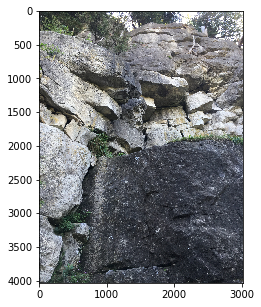

In [8]:
plt.rcParams['figure.figsize'] = 5, 5
temp = image.load_img('dataset_2/test_set/test_r2/IMG_3522.jpg')
plt.imshow(temp);

The goal is to train a neural network that would correctly classify the images in the test sets taken on the two days, using training data from *only one* data set.

A challenge we face in this problem is that we have a small amount of training data that is also highly correlated.  After all, for each route we are simply taking pictures of the same route from many positions.  Recall that we want to train the network on data collected on a single day in a short time period (consistent conditions).  This means that overfitting will be a serious risk, and we will be limited to deal with fairly shallow networks with a small number of nodes.  At the same time, we will want to be able to recognize images of routes under generic conditions and so the network must be sufficiently complex.  So far image pre-processing has been out main tool for acheiving sufficient complexity without overfitting.

We first preprocess the data by reducing the resolution from 768x1024 to 64x64 and then apply a median filter.  We may eventually want to use the full resolution images, perhaps broken into parts (left of route, center of route, etc) in order to utilize the data we have to the fullest.  But for now, we will see how far we can get by a brute force reduction of the resolution.  The resolution reduction and filter is a bit expensive time-wise, so it is better to perform these procedures once and for all and write the processed images to a directory.  This is done with the following code: 

In [3]:
# Create pre-processed training, validation and test subsets of the day 2 data
im_ht = 64
im_wd = 64
im_dim = im_ht

#Create data subsets of equal size (140) and rename in format to e.g. tr_r1_0.jpg.  Also creates validation subsets of equal
#size (60) and rename in format to e.g. val_r1_0.jpg

data_foulder = 'dataset_2/training_set/data_all' # folder to pull from
data_foulder_new = 'dataset_2/training_set/data_sub_64x64' # training dest
data_foulder_val = 'dataset_2/validation_set_64x64' # validation dest

data_foulder_test_from = 'dataset_2/test_set' # test dest
data_foulder_test_to = 'dataset_2/test_set_64x64' # test dest

if os.path.isdir(data_foulder_new): # delete the old data directory if it exists
    rmtree(data_foulder_new)
os.mkdir(data_foulder_new) # make a new data directory

if os.path.isdir(data_foulder_val): # delete the old data directory if it exists
    rmtree(data_foulder_val)
os.mkdir(data_foulder_val) # make a new data directory

if os.path.isdir(data_foulder_test_to): # delete the old data directory if it exists
    rmtree(data_foulder_test_to)
os.mkdir(data_foulder_test_to) # make a new data directory

#go through images for each route and create subsets
for route in os.listdir(data_foulder):
    if route != '.DS_Store':
        images = [image for image in os.listdir(data_foulder+'/'+route) if image != '.DS_Store'] 
        random.shuffle(images)
        
        #create resized training sets of equal size (140) and rename them in standard way
        os.mkdir(data_foulder_new+'/'+route)
        index = 0
        for image in images[0:140]: 
            image_resized = ndimage.median_filter(cv2.resize(np.array(imageio.imread(data_foulder+'/'+route+'/'+image)), (im_ht, im_wd)),5)
            Image.fromarray(image_resized).save(data_foulder_new+'/'+route+'/'+'tr_'+route[-2:]+'_'+str(index) + '.jpg')           
            index += 1
            
        #create resized validation subsets of equal size (60)
        os.mkdir(data_foulder_val+'/'+route)
        index = 0
        for image in images[140:200]: 
            image_resized = ndimage.median_filter(cv2.resize(np.array(imageio.imread(data_foulder+'/'+route+'/'+image)), (im_ht, im_wd)),5)
            Image.fromarray(image_resized).save(data_foulder_val+'/'+route+'/'+'val_'+route[-2:]+'_'+str(index) + '.jpg')           
            index += 1
            
        
#create resized test sets (slightly different sizes)       
for route in os.listdir(data_foulder_test_from):
    if route != '.DS_Store':
        test_images = [image for image in os.listdir(data_foulder_test_from+'/'+route) if image != '.DS_Store'] 
        
        os.mkdir(data_foulder_test_to+'/'+route)
        index = 0
        for image in test_images: 
            image_resized = ndimage.median_filter(cv2.resize(np.array(imageio.imread(data_foulder_test_from+'/'+route+'/'+image)), (im_ht, im_wd)),5)
            Image.fromarray(image_resized).save(data_foulder_test_to+'/'+route+'/'+'te_'+route[-2:]+'_'+str(index) + '.jpg')           
            index += 1
            
# create pre-processed test set of the day 1 data.  
data_foulder_test_from = 'dataset_1/test_set' # test dest
data_foulder_test_to = 'dataset_1/test_set_64x64' # test dest

if os.path.isdir(data_foulder_test_to): # delete the old data directory if it exists
    rmtree(data_foulder_test_to)
os.mkdir(data_foulder_test_to) # make a new data directory

for route in os.listdir(data_foulder_test_from):
    if route != '.DS_Store':
        test_images = [image for image in os.listdir(data_foulder_test_from+'/'+route) if image != '.DS_Store'] 
        
        os.mkdir(data_foulder_test_to+'/'+route)
        index = 0
        for image in test_images: 
            image_resized = ndimage.median_filter(cv2.resize(np.array(imageio.imread(data_foulder_test_from+'/'+route+'/'+image)), (im_ht, im_wd)),5)
            Image.fromarray(image_resized).save(data_foulder_test_to+'/'+route+'/'+'te_'+route[-2:]+'_'+str(index) + '.jpg')           
            index += 1

Now we can take a look at the preprocessed data:

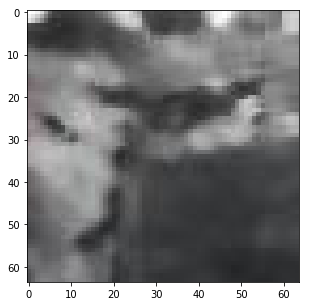

In [9]:
plt.rcParams['figure.figsize'] = 5, 5
temp = image.load_img('dataset_2/test_set_64x64/test_r2/te_r2_1.jpg', target_size = (im_dim, im_dim))
plt.imshow(temp, cmap='gray')

#  Step 1:  Same-day data

The first task is to get good predictions for training and test data collected under the same conditions (but by different people).  Good classification can be accomplished with a simple NN, but care must be taken not to overfit and overtrain.  

I found that a small network with a single convolution/pooling step with three layers and then a fullyconnected layer with 20 neurons performs well on the same-day data.  It consistenly performs at 99% test accuracy.  The network is constructed and tested below.

## The network 

First we constuct our network:

In [10]:
data_foulder = 'dataset_2'
im_dim = 64;

num_conv_lay = 3;
num_brain_lay = 20;

# Initialize the Convolution Neural Network (CNN)
classifier = Sequential()

# step 1&2 -- convolution and pooling
classifier.add(Conv2D(num_conv_lay,(3,3), input_shape = (im_dim, im_dim, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2,2)))

# step 3 -- Flattening
classifier.add(Flatten())

# step 4 -- Fully connected layers
classifier.add(Dense(units = num_brain_lay, activation = 'relu'))
# classifier.add(Dropout(0.5))
classifier.add(Dense(units = 4, activation = 'softmax'))

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])

# Fitting the CNN to the images
from keras.preprocessing.image import ImageDataGenerator

Now we augment the data using some standard techniques:

In [11]:
def avg_norm(img):
    '''renormalize average pixel value to 1'''
    return img/np.mean(img)

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   #brightness_range=[0.01,0.02],
                                   preprocessing_function = avg_norm)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   preprocessing_function = avg_norm)

training_set = train_datagen.flow_from_directory(data_foulder+'/training_set/data_sub_64x64',
                                            target_size = (im_dim, im_dim),
                                            batch_size = 20,    
                                            class_mode = 'categorical')

validation_set = valid_datagen.flow_from_directory(data_foulder+'/validation_set_64x64',
                                            target_size = (im_dim, im_dim),
                                            batch_size = 20,
                                            class_mode = 'categorical')

Found 560 images belonging to 4 classes.
Found 240 images belonging to 4 classes.


Finally we train the network:

In [12]:
from keras.callbacks import ModelCheckpoint 
filepath="weights/weights-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, mode='auto', period=1)

import os
from shutil import rmtree
if os.path.isdir('weights'): # delete the old data directory if it exists
    rmtree('weights')
os.mkdir('weights') # make a new data directory


classifier.fit_generator(training_set,
                         steps_per_epoch = 100,
                         epochs = 20,
                         validation_data = validation_set,
                         validation_steps = 10,
                         callbacks = [checkpoint]
                        )

Epoch 1/20
100/100 [==============================] - 4s 39ms/step - loss: 1.2713 - acc: 0.7615 - val_loss: 1.0329 - val_acc: 0.8333

Epoch 00001: saving model to weights/weights-01-0.83.hdf5
Epoch 2/20
100/100 [==============================] - 4s 35ms/step - loss: 0.7124 - acc: 0.9555 - val_loss: 0.3707 - val_acc: 0.9958

Epoch 00002: saving model to weights/weights-02-1.00.hdf5
Epoch 3/20
100/100 [==============================] - 3s 35ms/step - loss: 0.2654 - acc: 0.9925 - val_loss: 0.1303 - val_acc: 0.9958

Epoch 00003: saving model to weights/weights-03-1.00.hdf5
Epoch 4/20
100/100 [==============================] - 4s 36ms/step - loss: 0.1184 - acc: 0.9900 - val_loss: 0.0653 - val_acc: 1.0000

Epoch 00004: saving model to weights/weights-04-1.00.hdf5
Epoch 5/20
100/100 [==============================] - 4s 36ms/step - loss: 0.0710 - acc: 0.9925 - val_loss: 0.0338 - val_acc: 1.0000

Epoch 00005: saving model to weights/weights-05-1.00.hdf5
Epoch 6/20
100/100 [====================

## Testing the network 

Now we can see how our trained network performs on the two test sets (day 1 and day 2).  Note that the network is trained on the day 2 data only.  

In [13]:
def change_label(label):
    if label == 0:
        return 1
    elif label == 1:
        return 2
    elif label == 2:
        return 3
    elif label == 3:
        return 5
    
routes = ['r1', 'r2', 'r3', 'r5']

def my_score(data_foulder, weights):
    '''scores model with input weighs on test set in data_foulder'''
    
    classifier.load_weights(weights)
    
    count_wrong = 0
    count_right = 0
    missclass_2=[]
    for route in routes:

        test_images =  os.listdir(data_foulder+route)

        for img in test_images:
        
            if img != '.DS_Store':
        
                test_image = image.load_img(data_foulder+route+'/'+img,target_size = (im_dim, im_dim))
                test_image = image.img_to_array(test_image)
                test_image = avg_norm(np.expand_dims(test_image, axis = 0))
                result = change_label(np.argmax(classifier.predict(test_image)))
        
                if int(route[-1:]) != result:
                    count_wrong +=1
                    missclass_2.append(data_foulder+route+'/'+img)
                
                else:
                    count_right +=1
            
    return 1-float(count_wrong)/(count_right+count_wrong)

In [14]:
epoch_weights = sorted(os.listdir('weights'))
epoch_score_2 = []
epoch_score_1 = []
epoch_score_val = []
epoch_score_train = []
ticker=0
for weights in epoch_weights:
    if weights != '.DS_Store':
        ticker += 1
        print ticker
        epoch_score_1.append(my_score('dataset_1/test_set_64x64/test_','weights/'+weights))
        epoch_score_2.append(my_score('dataset_2/test_set_64x64/test_','weights/'+weights))
        epoch_score_val.append(my_score('dataset_2/validation_set_64x64/train_','weights/'+weights))
        epoch_score_train.append(my_score('dataset_2/training_set/data_sub_64x64/train_','weights/'+weights))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


Now we can plot the results:

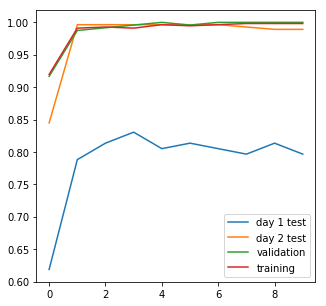

In [15]:
import pylab

my_range=10
pylab.plot(range(len(epoch_score_1[0:my_range])),epoch_score_1[0:my_range], label = 'day 1 test')
pylab.plot(range(len(epoch_score_1[0:my_range])),epoch_score_2[0:my_range], label = 'day 2 test')
pylab.plot(range(len(epoch_score_1[0:my_range])),epoch_score_val[0:my_range], label = 'validation')
pylab.plot(range(len(epoch_score_1[0:my_range])),epoch_score_train[0:my_range], label = 'training')
pylab.legend(loc='lower right')
pylab.show()

We should stop training right when the validation score stops improving significantly in order to not over-train.  

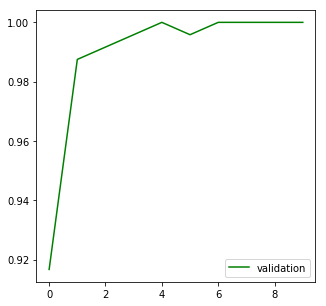

In [21]:
pylab.plot(range(len(epoch_score_1[0:my_range])),epoch_score_val[0:my_range],'-g', label = 'validation')
pylab.legend(loc='lower right')
pylab.show()

Validation improvement stops at epoch 4.  The day 2 and day 1 scores for epoch 4 are:

In [22]:
print epoch_score_2[4]
print epoch_score_1[4]

0.996389891697
0.805084745763


So we see that we do very well for the same day data.  Now we need must attempt to improve the different-day score.  As a first step I will try to mimic the different lighting in the data augmentation.

# Step 2:  different day data

ideas:

- more image preprocessing
- competing NN
- pre-trained conv/pooling stack

# Analysis of results

# Conclusions and future work